In [1]:
## Importing Required Libraries

from typing import Any, Tuple
import numpy as np

In [2]:
## Defining a normalize Function

def normalize(u: np.ndarray) -> np.ndarray:
    """
    Normalize a vector u with respect to itself
    :param u: (np.ndarray) Input vector
    :return: Normalized vector
    """
    return u / np.sum(u, axis=0, keepdims=True)


In [3]:
## Defining a Distance Function

def distance(u: np.ndarray, v: np.ndarray) -> float:
    """
    Calculate the euclidean distance between two vectors u and v
    :param u: (np.ndarray) First input vector
    :param v: (np.ndarray) Second input vector
    :return: (np.ndarray) Euclidean distance
    """
    v = np.expand_dims(np.transpose(v), 0)
    u = np.expand_dims(u, 2)

    return np.sqrt(np.sum((u - v) ** 2, axis=1))

In [4]:
## Creating a Clustering Class

class CMeansClustering:
    def __init__(self, n_clusters: int, error: float = 1e-4, max_iters: int = 200):
        """
        Constructor of C-Means Clustering
        :param n_clusters: (int) Number of clusters
        :param error: (float) Stop condition
        :param max_iters: (int) Total iteration number
        """
        self._n_clusters = n_clusters
        self._error = error
        self._max_iters = max_iters

        self._fuzzy_index = None
        self._fitted = None
        self._center = None
        self._train_u = None
        self._variance = None
        self._losses = None
        self._dimensions = None

    @property
    def center(self) -> np.ndarray:
        assert self._fitted, 'You need to fit the clustering algorithm first!'

        return self._center

    @property
    def delta(self) -> np.ndarray:
        assert self._fitted, 'You need to fit the clustering algorithm first!'

        return self._variance

    def fit(self, x: np.ndarray, y: np.ndarray = None) -> Any:
        """
        Fit a set of measurements to the model
        :param x: (np.ndarray) Vector with inputs
        :param y: (np.array) Vector with measurements
        :return: (CMeansClustering) self
        """
        if min(x.shape[0], x.shape[1] - 1) >= 3:
            self._fuzzy_index = min(x.shape[0], x.shape[1] - 1) / (min(x.shape[0], x.shape[1] - 1) - 2)
        else:
            self._fuzzy_index = 2

        n = x.shape[0]
        self._dimensions = x.shape[1]

        u = np.random.rand(self._n_clusters, n)

        self._losses = []

        for t in range(self._max_iters):
            u, v, loss, signal = self._update(x, u)
            self._losses.append(loss)
            print('\titer: {} - loss: {:.4f}'.format(t, loss))
            if signal:
                break

        self._fitted = True
        self._center = v
        self._train_u = u
        self._variance = np.zeros(self._center.shape)

        for i in range(self._dimensions):
            self._variance[:, i] = np.sum(
                u * ((x[:, i][:, np.newaxis] - self._center[:, i].transpose()) ** 2).T, axis=1
            ) / np.sum(u, axis=1)

        self._variance = np.fmax(self._variance, np.finfo(np.float64).eps)

        return self

    def _update(self, x: np.ndarray, u: np.ndarray) -> Tuple:
        """
        Update the internal state of the model
        :param x: (np.array) Input sample
        :param u: (np.array) Input vector
        :return: (Tuple) Vectors u,v and loss and signal
        """
        old_u = u.copy()
        old_u = np.fmax(old_u, np.finfo(np.float64).eps)
        old_u_prev = old_u.copy()

        old_u = normalize(old_u) ** self._fuzzy_index

        v = np.dot(old_u, x) / old_u.sum(axis=1, keepdims=True)

        dist = distance(x, v).T
        dist = np.fmax(dist, np.finfo(np.float64).eps)

        loss = (old_u * dist ** 2).sum()
        dist = dist ** (2 / (1 - self._fuzzy_index))
        dist = np.fmax(dist, np.finfo(np.float64).eps)

        u = normalize(dist)
        if np.linalg.norm(u - old_u_prev) < self._error:
            signal = True
        else:
            signal = False

        return u, v, loss, signal

In [5]:
## Importing Required Libraries

from scipy.special import softmax
from sklearn.linear_model import LogisticRegression

In [6]:
## Defining a new Function

def compute_firing_level(data: np.ndarray, centers: int, delta: float) -> np.ndarray:
    """
    Compute firing strength using Gaussian model
    :param data: n_Samples * n_Features
    :param centers: data center，n_Clusters * n_Features
    :param delta: variance of each feature， n_Clusters * n_Features
    :return: firing strength
    """
    d = -(np.expand_dims(data, axis=2) - np.expand_dims(centers.T, axis=0)) ** 2 / (2 * delta.T)
    d = np.exp(np.sum(d, axis=1))
    d = np.fmax(d, np.finfo(np.float64).eps)
    return d / np.sum(d, axis=1, keepdims=True)


In [7]:
## Defining another Function

def apply_firing_level(x: np.ndarray, firing_levels: np.ndarray, order: int = 1) -> np.ndarray:
    """
    Convert raw input to tsk input, based on the provided firing levels
    :param x: (np.ndarray) Raw input
    :param firing_levels: (np.ndarray) Firing level for each rule
    :param order: (int) TSK order. Valid values are 0 and 1
    :return:
    """
    if order == 0:
        return firing_levels
    else:
        n = x.shape[0]
        firing_levels = np.expand_dims(firing_levels, axis=1)
        x = np.expand_dims(np.concatenate((x, np.ones([n, 1])), axis=1), axis=2)
        x = np.repeat(x, repeats=firing_levels.shape[1], axis=2)
        output = x * firing_levels
        output = output.reshape([n, -1])

        return output

In [8]:
## Creating a class of takagi_sugeno_kang_fuzzy_system

class Classifier:
    def __init__(self, c: float = 1., max_iters: int = 200, n_cluster: int = 2, order: int = 1):
        """
        Fuzzy classifier class
        :param c: (float) c-coefficient for linear regressor estimator
        :param max_iters: (int) max iters for logistic regression fitting
        :param n_cluster: (int) Number of clusters
        :param order: (int) Order of the method. Valid values are 0 or 1
        """
        self._c = c
        self._max_iters = max_iters
        self._n_clusters = n_cluster
        self._order = order

        self._n_classes = None
        self._center = None
        self._variance = None
        self._regression = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> Any:
        """
        Fit a set of measurements to the model
        :param x: (np.ndarray) Vector with inputs
        :param y: (np.array) Vector with measurements
        :return: (Classifier) self
        """
        self._n_classes = len(np.unique(y))

        cluster = CMeansClustering(self._n_clusters).fit(x, y)

        self._center = cluster.center
        self._variance = cluster.delta

        mu_a = compute_firing_level(x, self._center, self._variance)
        computed_input = apply_firing_level(x, mu_a, self._order)

        self._regression = LogisticRegression(C=self._c, max_iter=self._max_iters)
        self._regression.fit(computed_input, y)

        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predict to which class a given set of inputs belongs
        :param x: (np.ndarray) Input vector
        :return: (np.ndarray) Output vector with predicted classes
        """
        firing_levels = compute_firing_level(x, self._center, self._variance)

        computed_input = apply_firing_level(x, firing_levels, self._order)

        logits = self._regression.decision_function(computed_input)

        return np.argmax(softmax(logits, axis=1), axis=1)

In [9]:
## Importing more required Libraries

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.model_selection import train_test_split
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings 
warnings.simplefilter('ignore')

In [10]:
## Defining a main function to fit the takagi_sugeno_kang_fuzzy_system

def main():
    """Entry point of the application"""
    # Loading the IRIS data
    iris = datasets.load_iris()

    # Selecting features and labels
    x = iris.data
    y = iris.target

    # prepare train/test split
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

    print(f'Number of training samples: {len(x_train)}')
    print(f'Number of test samples: {len(x_test)}')

    # fit the fuzzy classifier
    cls = Classifier()

    print('Fitting classifier to data:')

    cls.fit(x_train, y_train)

    # predict
    y_pred = cls.predict(x_test)
    print(f'Predicting unseen data: {y_pred}')

    accuracy = accuracy_score(y_test, y_pred)
    print(f'accuracy: {accuracy}')


In [13]:
## Creating Variables
seplen = np.arange(4.3, 8.0, 0.1)
sepwid = np.arange(2.0, 4.5, 0.1)
petlen = np.arange(1.0, 7.0, 0.1)
petwid = np.arange(0.1, 2.6, 0.1)

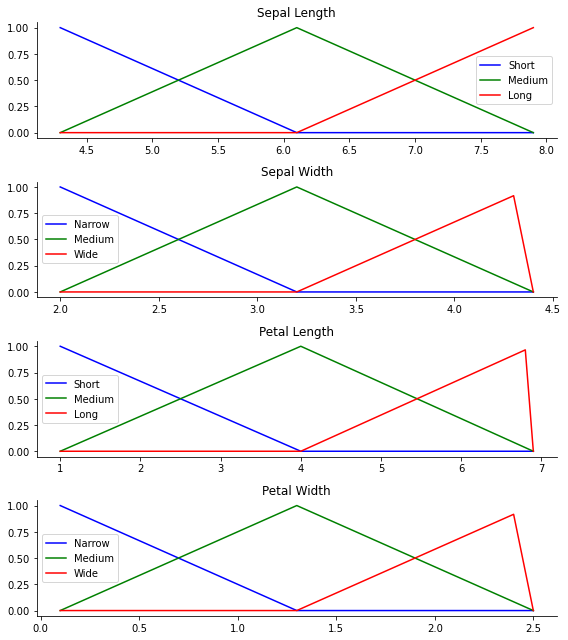

In [16]:
import matplotlib.pyplot as plt

## Creation of Membership Function for Sepal Length
seplen_low = fuzz.trimf(seplen, [4.3,4.3,6.1])
seplen_med = fuzz.trimf(seplen, [4.3,6.1,7.9])
seplen_high = fuzz.trimf(seplen, [6.1,7.9,7.9])
sepwid_low = fuzz.trimf(sepwid, [2,2,3.2])
sepwid_med = fuzz.trimf(sepwid, [2,3.2,4.4])
sepwid_high = fuzz.trimf(sepwid, [3.2,4.4,4.4])
petlen_low = fuzz.trimf(petlen, [1,1,4])
petlen_med = fuzz.trimf(petlen, [1,4,6.9])
petlen_high = fuzz.trimf(petlen, [4,6.9,6.9])
petwid_low = fuzz.trimf(petwid, [0.1,0.1,1.3])
petwid_med = fuzz.trimf(petwid, [0.1,1.3,2.5])
petwid_high = fuzz.trimf(petwid, [1.3,2.5,2.5])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(8, 9))

ax0.plot(seplen, seplen_low, 'b', linewidth=1.5, label='Short')
ax0.plot(seplen, seplen_med, 'g', linewidth=1.5, label='Medium')
ax0.plot(seplen, seplen_high, 'r', linewidth=1.5, label='Long')
ax0.set_title('Sepal Length')
ax0.legend()

ax1.plot(sepwid, sepwid_low, 'b', linewidth=1.5, label='Narrow')
ax1.plot(sepwid, sepwid_med, 'g', linewidth=1.5, label='Medium')
ax1.plot(sepwid, sepwid_high, 'r', linewidth=1.5, label='Wide')
ax1.set_title('Sepal Width')
ax1.legend()

ax2.plot(petlen, petlen_low, 'b', linewidth=1.5, label='Short')
ax2.plot(petlen, petlen_med, 'g', linewidth=1.5, label='Medium')
ax2.plot(petlen, petlen_high, 'r', linewidth=1.5, label='Long')
ax2.set_title('Petal Length')
ax2.legend()

ax3.plot(petwid, petwid_low, 'b', linewidth=1.5, label='Narrow')
ax3.plot(petwid, petwid_med, 'g', linewidth=1.5, label='Medium')
ax3.plot(petwid, petwid_high, 'r', linewidth=1.5, label='Wide')
ax3.set_title('Petal Width')
ax3.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
plt.tight_layout()

In [18]:
## Calling the main Function to get output
main()

Number of training samples: 120
Number of test samples: 30
Fitting classifier to data:
	iter: 0 - loss: 213.1557
	iter: 1 - loss: 132.8352
	iter: 2 - loss: 126.2244
	iter: 3 - loss: 103.8341
	iter: 4 - loss: 74.2608
	iter: 5 - loss: 66.0778
	iter: 6 - loss: 65.6199
	iter: 7 - loss: 65.5946
	iter: 8 - loss: 65.5921
	iter: 9 - loss: 65.5918
	iter: 10 - loss: 65.5918
	iter: 11 - loss: 65.5918
	iter: 12 - loss: 65.5918
	iter: 13 - loss: 65.5918
Predicting unseen data: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]
accuracy: 1.0


In [19]:
## Notebook Ended
## Notebook Ended
## Notebook Ended
## Notebook Ended
## Notebook Ended